<a href="https://colab.research.google.com/github/peterw3348/EchoCommand/blob/main/EchoCommand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EchoCommand: Audio-Based Speech Classification for Accessibility

## Project Directory

*   Model Demo: https://colab.research.google.com/drive/1JiB3N6oaqlyRprsLCPmxOzF4pyXtjC_v?usp=sharing
*   Dataset Splitting: https://colab.research.google.com/drive/1CYRj_Si-ArXeJEJGuJxkUafmbV59l5kI?usp=sharing
*   Saliency Maps Testing: https://colab.research.google.com/drive/1pVQzH_CuoOx_8RQ3PZCzRySuY1sUQEV0?usp=sharing
*   Confusion Matrix Testing: https://colab.research.google.com/drive/1uCuciKDBaq4j_Tv6m5BFKiFZo86R_wn2?usp=sharing
*   Baseline Model: https://colab.research.google.com/drive/12da2-QgYnLf-4M1CadTB6wmK-OnLoA1f?usp=sharing
*   Recording Audio: https://colab.research.google.com/drive/1BvKVb9kglz8C6Aya9Zf8HFH5x1Nx3oIF?usp=sharing

## Installing Dependancies

In [ ]:
!pip install dataclasses==0.6

In [ ]:
!pip install torch==1.7.0

ERROR: Could not find a version that satisfies the requirement torch==1.7.0 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0)
ERROR: No matching distribution found for torch==1.7.0


In [ ]:
!pip install torchvision==0.8.1

     |████████████████████████████████| 12.7MB 314kB/s 
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
!pip install torchaudio==0.7.0

     |████████████████████████████████| 7.6MB 11.7MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets , models
from torch.utils.data import Dataset
import torchaudio
from torchaudio import transforms, functional
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from IPython.display import Audio, display

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


## Loading data onto local runtime

Warden P., "Launching the Speech Commands Dataset", Google AI Blog, August 24, 2017. [Online]. Accessed: Mar. 12, 2021. Available: https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html.

In [ ]:
!unzip /content/Testing_Data-20210404T212802Z-001.zip

In [ ]:
!unzip /content/Training_Data-20210404T044446Z-001.zip

Archive:  /content/Training_Data-20210404T044446Z-001.zip
replace Training_Data/six/82c6d220_nohash_0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip /content/Validation_Data-20210404T212800Z-001.zip

Archive:  /content/Validation_Data-20210404T212800Z-001.zip
replace Validation_Data/bed/a7dd45cf_nohash_0.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip /content/background_noise_norm-20210404T214739Z-001.zip

Archive:  /content/background_noise_norm-20210404T214739Z-001.zip
replace background_noise_norm/37running_tap.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# train_path = "/content/drive/MyDrive/Training_Data"
# val_path = "/content/drive/MyDrive/Validation_Data"
# test_path = "/content/drive/MyDrive/Testing_Data"
# bg_noise_path = "/content/drive/MyDrive/background_noise_norm"

Mounted at /content/drive


## Data Processing


The spliting of data is done in another notebook. 75/13/12 training, validation and testing splits.

The following uses code from:

PyTorch, "Audio manipulation with torchaudio", PyTorch, 2017. [Online]. Accessed: Apr. 5th, 2021. Available: https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

In [ ]:
def audio_load(path):
    tensor, freq = torchaudio.load(path)
    return (tensor, freq)
val = audio_load("/content/drive/MyDrive/Training_Data/bed/00176480_nohash_0.wav")
print(val)

(tensor([[ 9.1553e-05,  3.0518e-05,  1.8311e-04,  ..., -3.0518e-05,
         -9.1553e-05,  1.2207e-04]]), 16000)


In [ ]:
noise_names = os.listdir(bg_noise_path)
noises = list()
for name in noise_names:
  tensor, freq = torchaudio.load(bg_noise_path + "/" + name)
  noises.append(tensor)
def get_random_bg_noise():
  idx = np.random.randint(len(noises))
  return noises[idx]

In [ ]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate,autoplay=True))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate,autoplay=True))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

In [ ]:
def transform_spec(pack):
    word, sr = pack
    plot_specgram(word, sr)
    batch_effect = np.random.randint(15)
    if batch_effect == 9:
      sr_final = sr
      noise = get_random_bg_noise()
      noise = noise[:, :word.shape[1]]
      final = noise*2.5 + word
    elif batch_effect == 1:
        range = np.random.randint(100,3000)
        effects = [
        ["lowpass", "-1", str(range)],
        ]
    elif batch_effect == 2:
        range = np.random.randint(70,130)
        effects = [
        ["speed", str(range/100)],
        ["rate", f"{sr}"],
        ]
    elif batch_effect == 3:
        effects = [
        ["reverb", "-w"],
        ["channels","1"]
        ]
    elif batch_effect == 4:
        range = np.random.randint(70,130)
        effects = [
        ["tempo", "-q","-s", str(range/100)],
        ["rate", f"{sr}"],
        ]
    elif batch_effect == 5:
        range = np.random.randint(1,50)
        effects = [
        ["bass", str(range)],
        ]
    elif batch_effect == 6:
        range = np.random.randint(1,50)
        effects = [
        ["treble", str(range)],
        ]
    elif batch_effect == 7:
        range = np.random.randint(50,90)
        range2 = range + np.random.randint(5,10)
        delay = np.random.randint(2000,3000)
        range3 = np.random.randint(20,70)
        effects = [
        ["echo", str(range/100),str(range2/100),str(delay/100),str(range3/100)],
        ]
    elif batch_effect == 8:
        range = np.random.randint(1000,7000)
        effects = [
        ["highpass", "-1",  "4000"],
        ]
    elif batch_effect == 9:
        range = np.random.randint(1000,7000)
        effects = [
        ["bandpass", str(range), "3000"],
        ]
    elif batch_effect == 10:
        range = np.random.randint(1000,8000)
        effects = [
        ["bandreject", str(range), "4000"],
        ]
    # elif batch_effect == 11:
    #     effects = [
    #     ["tremolo speed", "16000"],
    #     ]
    else:
        sr_final = sr
        final = word
    if(batch_effect != 0 and batch_effect <= 10):
        effects.append(['pad','0','1'])
        effects.append(['trim','0','1'])
        final, sr_final = torchaudio.sox_effects.apply_effects_tensor(word, sr, effects)
    plot_specgram(final, sr_final)
    play_audio(final, 16000)
    specgram = torchaudio.transforms.Spectrogram()(final)
    specgram = specgram.repeat(3, 1, 1)
    specgram = np.transpose(specgram.numpy(), (1,2,0))
    specgram = np.transpose(specgram,(2,0,1)).astype(np.float32)
    tensor = torch.tensor(specgram, dtype = torch.float)
    tensor = torchvision.transforms.Resize([201,30])(tensor)
    print(batch_effect)
    return tensor
path_test = "/content/drive/MyDrive/Training_Data/stop/004ae714_nohash_0.wav"
pack = torchaudio.load(path_test)
output = transform_spec(pack)

print(output.shape)

NameError: ignored

In [ ]:
def transform_spec_no_aug(pack):
    word, sr = pack
    specgram = torchaudio.transforms.Spectrogram()(word)
    specgram = specgram.repeat(3, 1, 1)
    specgram = np.transpose(specgram.numpy(), (1,2,0))
    specgram = np.transpose(specgram,(2,0,1)).astype(np.float32)
    tensor = torch.tensor(specgram, dtype = torch.float)
    tensor = torchvision.transforms.Resize([201,30])(tensor)
    return tensor

In [ ]:
commands_dataset = datasets.DatasetFolder(root=train_path, loader=audio_load, transform=transform_spec, extensions=".wav")
loaded_data = torch.utils.data.DataLoader(commands_dataset, batch_size=50)

In [ ]:
#Mapping of label names to label numbers
print(commands_dataset.class_to_idx)
print(commands_dataset.classes)

{'bed': 0, 'bird': 1, 'cat': 2, 'dog': 3, 'down': 4, 'eight': 5, 'five': 6, 'four': 7, 'go': 8, 'happy': 9, 'house': 10, 'left': 11, 'marvin': 12, 'nine': 13, 'no': 14, 'off': 15, 'on': 16, 'one': 17, 'right': 18, 'seven': 19, 'sheila': 20, 'six': 21, 'stop': 22, 'three': 23, 'tree': 24, 'two': 25, 'up': 26, 'wow': 27, 'yes': 28, 'zero': 29}
['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


Code that was used to check the minimum size of the spectrograms

In [ ]:
# When put into a dataloader and iterating, it will return ([audio_as_tensor, sampling_frequency], label)
# You can extract using(a,b),c

# import math
# min_num = math.inf
# for tensor, label in loaded_data:
#     if torch.cuda.is_available():
#             tensor = tensor.cuda() # Moves tensor from CPU to GPU

#     if tensor.shape[2] < min_num:
#         min_num = tensor.shape[2]
#         print(min_num)
# print(min_num)

In [ ]:
# When put into a dataloader and iterating, it will return ([audio_as_tensor, sampling_frequency], label)
# You can extract using(a,b),c
# commands_dataset = datasets.DatasetFolder(root=train_path, loader=audio_load, transform=transform_spec, extensions=".wav")
# loaded_data = torch.utils.data.DataLoader(commands_dataset, batch_size=50)

# for tensor, label in loaded_data:
#   print(type(tensor))
#   print(tensor)
#   print(tensor.shape)


#   print(type(label))
#   print(label)
#   break

## Preparing dataloaders

In [ ]:
def get_data_loader(batch_size):
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    train = datasets.DatasetFolder(root=train_path, loader=audio_load, transform=transform_spec, extensions=".wav")
    val = datasets.DatasetFolder(root=val_path, loader=audio_load, transform=transform_spec_no_aug, extensions=".wav")
    test = datasets.DatasetFolder(root=test_path, loader=audio_load, transform=transform_spec_no_aug, extensions=".wav")
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                               num_workers=4, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                              num_workers=4)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                              num_workers=4)
    return train_loader, val_loader, test_loader


## Model Architecture

**Load the trained model from the drive:**


1.   Run the AudioClassifier cell
2.   Load the model using `torch.load()`



The model architecture is based on code from:

“Audio Classification Using CNN — Coding Example”, Medium.com, 2019. [Online]. Accessed on Feb 18th, 2021. Available: https://medium.com/x8-the-ai-community/audio-classification-using-cnn-coding-example-f9cbd272269e

In [ ]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, kernel_size = 5)
        self.conv2 = nn.Conv2d(5, 10, kernel_size = 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.9)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(10 * 47 * 4, 1960)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1960, 30)

    def forward(self, x):
        # 3 x 201 x 30
        x = self.pool(F.relu(self.conv1(x)))
        # 5 x 197 x 26 -> 5 x 98 x 13
        x = self.pool(F.relu(self.conv2(x)))
        # 10 x 94 x 9 -> 10 x 47 x 4
        x = x.view(-1, 10 * 47 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# model_path = "/content/drive/MyDrive/Model/model.pth"
# model = torch.load(model_path)

In [ ]:
def get_val_loss(model, loader, criterion):
    total_loss = 0.0
    n = 0
    for data, labels in loader:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          data = data.cuda() # Moves tensor from CPU to GPU
          labels = labels.cuda()
        #############################################
        outputs = model(data)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        n += 1
    return float(loss)/(n + 1)

def get_accuracy(model, loader):
    correct = 0
    total = 0
    for data, labels in loader:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          data = data.cuda() # Moves tensor from CPU to GPU
          labels = labels.cuda()
        #############################################

        output = model(data)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += data.shape[0]
    return correct / total

In [ ]:
def get_model_name(batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_bs{0}_lr{1}_epoch{2}".format(batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def train(model, learning_rate=0.001, batch_size=500, num_epochs=15, print_trace=True):

    train_loader, val_loader, test_loader = get_data_loader(batch_size)

    # Use CrossEntropyLoss for multi-class classification
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Set up some arrays to store the training/test loss/accuracy
    iters, train_acc, train_loss, val_loss, val_acc = [], [], [], [], []
    n = 0
    print("done setup")

    # Main Training Loop
    for epoch in range(num_epochs):
        print("epoch")
        for data, labels in train_loader:
            print("begin:"+str(n*batch_size))
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              data = data.cuda() # Moves tensor from CPU to GPU
              labels = labels.cuda()
            print("middle:"+str(n*batch_size))
            #############################################

            outputs = model(data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            print("end:"+str(n*batch_size))

            n += 1

        # Calculate statistics
        iters.append(n)
        train_loss.append(get_val_loss(model, train_loader, criterion))   # compute training loss
        val_loss.append(get_val_loss(model, val_loader, criterion))       # compute validation loss
        train_acc.append(get_accuracy(model, train_loader))               # compute training accuracy
        val_acc.append(get_accuracy(model, val_loader))                   # compute validation accuracy

        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
            "Validation acc: {}, Validation loss: {}").format(
                epoch + 1,
                train_acc[-1],
                train_loss[-1],
                val_acc[-1],
                val_loss[-1]))

        # Store current epoch as a checkpoint
        model_path = get_model_name(batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path+".pth")

    print("Finished training")

    # plotting
    # Loss Curves
    plt.title("Loss")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    # Accuracy Curves
    plt.title("Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Best Training Result So Far

CUDA is available!  Training on GPU ...
done setup
epoch
begin:0
middle:0
end:0
begin:1500
middle:1500
end:1500
begin:3000
middle:3000
end:3000
begin:4500
middle:4500
end:4500
begin:6000
middle:6000
end:6000
begin:7500
middle:7500
end:7500
begin:9000
middle:9000
end:9000
begin:10500
middle:10500
end:10500
begin:12000
middle:12000
end:12000
begin:13500
middle:13500
end:13500
begin:15000
middle:15000
end:15000
begin:16500
middle:16500
end:16500
begin:18000
middle:18000
end:18000
begin:19500
middle:19500
end:19500
begin:21000
middle:21000
end:21000
begin:22500
middle:22500
end:22500
begin:24000
middle:24000
end:24000
begin:25500
middle:25500
end:25500
begin:27000
middle:27000
end:27000
begin:28500
middle:28500
end:28500
begin:30000
middle:30000
end:30000
begin:31500
middle:31500
end:31500
begin:33000
middle:33000
end:33000
begin:34500
middle:34500
end:34500
begin:36000
middle:36000
end:36000
begin:37500
middle:37500
end:37500
begin:39000
middle:39000
end:39000
begin:40500
middle:40500
end

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert s

begin:388500
middle:388500
end:388500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:390000
middle:390000
end:390000
begin:391500
middle:391500
end:391500
begin:393000
middle:393000
end:393000
begin:394500
middle:394500
end:394500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
    self._shutdown_workers()
  F

Epoch 8: Train acc: 0.4390935430463576, Train loss: 0.05837871747858384 |Validation acc: 0.46993395898505386, Validation loss: 0.23780112607138498
epoch
begin:396000
middle:396000
end:396000
begin:397500
middle:397500
end:397500
begin:399000
middle:399000
end:399000
begin:400500
middle:400500
end:400500
begin:402000
middle:402000
end:402000
begin:403500
middle:403500
end:403500
begin:405000
middle:405000
end:405000
begin:406500
middle:406500
end:406500
begin:408000
middle:408000
end:408000
begin:409500
middle:409500
end:409500
begin:411000
middle:411000
end:411000
begin:412500
middle:412500
end:412500
begin:414000
middle:414000
end:414000
begin:415500
middle:415500
end:415500
begin:417000
middle:417000
end:417000
begin:418500
middle:418500
end:418500
begin:420000
middle:420000
end:420000
begin:421500
middle:421500
end:421500
begin:423000
middle:423000
end:423000
begin:424500
middle:424500
end:424500
begin:426000
middle:426000
end:426000
begin:427500
middle:427500
end:427500
begin:42900

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:438000
middle:438000
end:438000
begin:439500
middle:439500
end:439500
begin:441000
middle:441000
end:441000
begin:442500
middle:442500
end:442500
begin:444000
middle:444000
end:444000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/u

Epoch 9: Train acc: 0.4723096026490066, Train loss: 0.05452707585166482 |Validation acc: 0.49982620785540494, Validation loss: 0.24241113662719727
epoch
begin:445500
middle:445500
end:445500
begin:447000
middle:447000
end:447000
begin:448500
middle:448500
end:448500
begin:450000
middle:450000
end:450000
begin:451500
middle:451500
end:451500
begin:453000
middle:453000
end:453000
begin:454500
middle:454500
end:454500
begin:456000
middle:456000
end:456000
begin:457500
middle:457500
end:457500
begin:459000
middle:459000
end:459000
begin:460500
middle:460500
end:460500
begin:462000
middle:462000
end:462000
begin:463500
middle:463500
end:463500
begin:465000
middle:465000
end:465000
begin:466500
middle:466500
end:466500
begin:468000
middle:468000
end:468000
begin:469500
middle:469500
end:469500
begin:471000
middle:471000
end:471000
begin:472500
middle:472500
end:472500
begin:474000
middle:474000
end:474000
begin:475500
middle:475500
end:475500
begin:477000
middle:477000
end:477000
begin:47850

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7

begin:487500
middle:487500
end:487500
begin:489000
middle:489000
end:489000
begin:490500
middle:490500
end:490500
begin:492000
middle:492000
end:492000
begin:493500
middle:493500
end:493500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 10: Train acc: 0.4892591059602649, Train loss: 0.05418178965063656 |Validation acc: 0.5191750666203221, Validation loss: 0.22184567792075022
epoch
begin:495000
middle:495000
end:495000
begin:496500
middle:496500
end:496500
begin:498000
middle:498000
end:498000
begin:499500
middle:499500
end:499500
begin:501000
middle:501000
end:501000
begin:502500
middle:502500
end:502500
begin:504000
middle:504000
end:504000
begin:505500
middle:505500
end:505500
begin:507000
middle:507000
end:507000
begin:508500
middle:508500
end:508500
begin:510000
middle:510000
end:510000
begin:511500
middle:511500
end:511500
begin:513000
middle:513000
end:513000
begin:514500
middle:514500
end:514500
begin:516000
middle:516000
end:516000
begin:517500
middle:517500
end:517500
begin:519000
middle:519000
end:519000
begin:520500
middle:520500
end:520500
begin:522000
middle:522000
end:522000
begin:523500
middle:523500
end:523500
begin:525000
middle:525000
end:525000
begin:526500
middle:526500
end:526500
begin:52800

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignore

begin:537000
middle:537000
end:537000


  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


begin:538500
middle:538500
end:538500
begin:540000
middle:540000
end:540000
begin:541500
middle:541500
end:541500
begin:543000
middle:543000
end:543000
Epoch 11: Train acc: 0.5122102649006622, Train loss: 0.05224455104154699 |Validation acc: 0.5423473525663307, Validation loss: 0.21643163476671493
epoch
begin:544500
middle:544500
end:544500
begin:546000
middle:546000
end:546000
begin:547500
middle:547500
end:547500
begin:549000
middle:549000
end:549000
begin:550500
middle:550500
end:550500
begin:552000
middle:552000
end:552000
begin:553500
middle:553500
end:553500
begin:555000
middle:555000
end:555000
begin:556500
middle:556500
end:556500
begin:558000
middle:558000
end:558000
begin:559500
middle:559500
end:559500
begin:561000
middle:561000
end:561000
begin:562500
middle:562500
end:562500
begin:564000
middle:564000
end:564000
begin:565500
middle:565500
end:565500
begin:567000
middle:567000
end:567000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:568500
middle:568500
end:568500
begin:570000
middle:570000
end:570000
begin:571500
middle:571500
end:571500
begin:573000
middle:573000
end:573000
begin:574500
middle:574500
end:574500
begin:576000
middle:576000
end:576000
begin:577500
middle:577500
end:577500
begin:579000
middle:579000
end:579000
begin:580500
middle:580500
end:580500
begin:582000
middle:582000
end:582000
begin:583500
middle:583500
end:583500
begin:585000
middle:585000
end:585000
begin:586500
middle:586500
end:586500
begin:588000
middle:588000
end:588000
begin:589500
middle:589500
end:589500
begin:591000
middle:591000
end:591000
begin:592500
middle:592500
end:592500
Epoch 12: Train acc: 0.534830298013245, Train loss: 0.05165534860947553 |Validation acc: 0.5578727841501564, Validation loss: 0.23497462272644043
epoch
begin:594000
middle:594000
end:594000
begin:595500
middle:595500
end:595500
begin:597000
middle:597000
end:597000
begin:598500
middle:598500
end:598500
begin:600000
middle:600000
end:600000
begin:601500

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:618000
middle:618000
end:618000
begin:619500
middle:619500
end:619500
begin:621000
middle:621000
end:621000
begin:622500
middle:622500
end:622500
begin:624000
middle:624000
end:624000
begin:625500
middle:625500
end:625500
begin:627000
middle:627000
end:627000
begin:628500
middle:628500
end:628500
begin:630000
middle:630000
end:630000
begin:631500
middle:631500
end:631500
begin:633000
middle:633000
end:633000
begin:634500
middle:634500
end:634500
begin:636000
middle:636000
end:636000
begin:637500
middle:637500
end:637500
begin:639000
middle:639000
end:639000
begin:640500
middle:640500
end:640500
begin:642000
middle:642000
end:642000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/u

Epoch 13: Train acc: 0.55716059602649, Train loss: 0.04072640923892751 |Validation acc: 0.5822036843934654, Validation loss: 0.2255927494594029
epoch
begin:643500
middle:643500
end:643500
begin:645000
middle:645000
end:645000
begin:646500
middle:646500
end:646500
begin:648000
middle:648000
end:648000
begin:649500
middle:649500
end:649500
begin:651000
middle:651000
end:651000
begin:652500
middle:652500
end:652500
begin:654000
middle:654000
end:654000
begin:655500
middle:655500
end:655500
begin:657000
middle:657000
end:657000
begin:658500
middle:658500
end:658500
begin:660000
middle:660000
end:660000
begin:661500
middle:661500
end:661500
begin:663000
middle:663000
end:663000
begin:664500
middle:664500
end:664500
begin:666000
middle:666000
end:666000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:667500
middle:667500
end:667500
begin:669000
middle:669000
end:669000
begin:670500
middle:670500
end:670500
begin:672000
middle:672000
end:672000
begin:673500
middle:673500
end:673500
begin:675000
middle:675000
end:675000
begin:676500
middle:676500
end:676500
begin:678000
middle:678000
end:678000
begin:679500
middle:679500
end:679500
begin:681000
middle:681000
end:681000
begin:682500
middle:682500
end:682500
begin:684000
middle:684000
end:684000
begin:685500
middle:685500
end:685500
begin:687000
middle:687000
end:687000
begin:688500
middle:688500
end:688500
begin:690000
middle:690000
end:690000
begin:691500
middle:691500
end:691500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    self._shutdown_workers()
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert s

Epoch 14: Train acc: 0.5684395695364238, Train loss: 0.05037982674206004 |Validation acc: 0.5885760630286178, Validation loss: 0.20321897097996303
epoch
begin:693000
middle:693000
end:693000
begin:694500
middle:694500
end:694500
begin:696000
middle:696000
end:696000
begin:697500
middle:697500
end:697500
begin:699000
middle:699000
end:699000
begin:700500
middle:700500
end:700500
begin:702000
middle:702000
end:702000
begin:703500
middle:703500
end:703500
begin:705000
middle:705000
end:705000
begin:706500
middle:706500
end:706500
begin:708000
middle:708000
end:708000
begin:709500
middle:709500
end:709500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:711000
middle:711000
end:711000
begin:712500
middle:712500
end:712500
begin:714000
middle:714000
end:714000
begin:715500
middle:715500
end:715500
begin:717000
middle:717000
end:717000
begin:718500
middle:718500
end:718500
begin:720000
middle:720000
end:720000
begin:721500
middle:721500
end:721500
begin:723000
middle:723000
end:723000
begin:724500
middle:724500
end:724500
begin:726000
middle:726000
end:726000
begin:727500
middle:727500
end:727500
begin:729000
middle:729000
end:729000
begin:730500
middle:730500
end:730500
begin:732000
middle:732000
end:732000
begin:733500
middle:733500
end:733500
begin:735000
middle:735000
end:735000
begin:736500
middle:736500
end:736500
begin:738000
middle:738000
end:738000
begin:739500
middle:739500
end:739500
begin:741000
middle:741000
end:741000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 15: Train acc: 0.5893004966887417, Train loss: 0.04086257079068352 |Validation acc: 0.6009732360097324, Validation loss: 0.19772849764142716
epoch
begin:742500
middle:742500
end:742500
begin:744000
middle:744000
end:744000
begin:745500
middle:745500
end:745500
begin:747000
middle:747000
end:747000
begin:748500
middle:748500
end:748500
begin:750000
middle:750000
end:750000
begin:751500
middle:751500
end:751500
begin:753000
middle:753000
end:753000
begin:754500
middle:754500
end:754500
begin:756000
middle:756000
end:756000
begin:757500
middle:757500
end:757500
begin:759000
middle:759000
end:759000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:760500
middle:760500
end:760500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
AssertionError: can only join a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:762000
middle:762000
end:762000
begin:763500
middle:763500
end:763500
begin:765000
middle:765000
end:765000
begin:766500
middle:766500
end:766500
begin:768000
middle:768000
end:768000
begin:769500
middle:769500
end:769500
begin:771000
middle:771000
end:771000
begin:772500
middle:772500
end:772500
begin:774000
middle:774000
end:774000
begin:775500
middle:775500
end:775500
begin:777000
middle:777000
end:777000
begin:778500
middle:778500
end:778500
begin:780000
middle:780000
end:780000
begin:781500
middle:781500
end:781500
begin:783000
middle:783000
end:783000
begin:784500
middle:784500
end:784500
begin:786000
middle:786000
end:786000
begin:787500
middle:787500
end:787500
begin:789000
middle:789000
end:789000
begin:790500
middle:790500
end:790500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 16: Train acc: 0.6026283112582781, Train loss: 0.04400062911650714 |Validation acc: 0.6181207276097787, Validation loss: 0.19632785660879953
epoch
begin:792000
middle:792000
end:792000
begin:793500
middle:793500
end:793500
begin:795000
middle:795000
end:795000
begin:796500
middle:796500
end:796500
begin:798000
middle:798000
end:798000
begin:799500
middle:799500
end:799500
begin:801000
middle:801000
end:801000
begin:802500
middle:802500
end:802500
begin:804000
middle:804000
end:804000
begin:805500
middle:805500
end:805500
begin:807000
middle:807000
end:807000
begin:808500
middle:808500
end:808500
begin:810000
middle:810000
end:810000
begin:811500
middle:811500
end:811500
begin:813000
middle:813000
end:813000
begin:814500
middle:814500
end:814500
begin:816000
middle:816000
end:816000
begin:817500
middle:817500
end:817500
begin:819000
middle:819000
end:819000
begin:820500
middle:820500
end:820500
begin:822000
middle:822000
end:822000
begin:823500
middle:823500
end:823500
begin:82500

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:828000
middle:828000
end:828000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:829500
middle:829500
end:829500
begin:831000
middle:831000
end:831000
begin:832500
middle:832500
end:832500
begin:834000
middle:834000
end:834000
begin:835500
middle:835500
end:835500
begin:837000
middle:837000
end:837000
begin:838500
middle:838500
end:838500
begin:840000
middle:840000
end:840000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 17: Train acc: 0.6162458609271523, Train loss: 0.041166512405171114 |Validation acc: 0.6192793419070791, Validation loss: 0.19999636922563827
epoch
begin:841500
middle:841500
end:841500
begin:843000
middle:843000
end:843000
begin:844500
middle:844500
end:844500
begin:846000
middle:846000
end:846000
begin:847500
middle:847500
end:847500
begin:849000
middle:849000
end:849000
begin:850500
middle:850500
end:850500
begin:852000
middle:852000
end:852000
begin:853500
middle:853500
end:853500
begin:855000
middle:855000
end:855000
begin:856500
middle:856500
end:856500
begin:858000
middle:858000
end:858000
begin:859500
middle:859500
end:859500
begin:861000
middle:861000
end:861000
begin:862500
middle:862500
end:862500
begin:864000
middle:864000
end:864000
begin:865500
middle:865500
end:865500
begin:867000
middle:867000
end:867000
begin:868500
middle:868500
end:868500
begin:870000
middle:870000
end:870000
begin:871500
middle:871500
end:871500
begin:873000
middle:873000
end:873000
begin:8745

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 19: Train acc: 0.6337127483443709, Train loss: 0.036785006523132324 |Validation acc: 0.6409454292665971, Validation loss: 0.18469326836722239
epoch
begin:940500
middle:940500
end:940500
begin:942000
middle:942000
end:942000
begin:943500
middle:943500
end:943500
begin:945000
middle:945000
end:945000
begin:946500
middle:946500
end:946500
begin:948000
middle:948000
end:948000
begin:949500
middle:949500
end:949500
begin:951000
middle:951000
end:951000
begin:952500
middle:952500
end:952500
begin:954000
middle:954000
end:954000
begin:955500
middle:955500
end:955500
begin:957000
middle:957000
end:957000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:958500
middle:958500
end:958500
begin:960000
middle:960000
end:960000
begin:961500
middle:961500
end:961500
begin:963000
middle:963000
end:963000
begin:964500
middle:964500
end:964500
begin:966000
middle:966000
end:966000
begin:967500
middle:967500
end:967500
begin:969000
middle:969000
end:969000
begin:970500
middle:970500
end:970500
begin:972000
middle:972000
end:972000
begin:973500
middle:973500
end:973500
begin:975000
middle:975000
end:975000
begin:976500
middle:976500
end:976500
begin:978000
middle:978000
end:978000
begin:979500
middle:979500
end:979500
begin:981000
middle:981000
end:981000
begin:982500
middle:982500
end:982500
begin:984000
middle:984000
end:984000
begin:985500
middle:985500
end:985500
begin:987000
middle:987000
end:987000
begin:988500
middle:988500
end:988500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/u

Epoch 20: Train acc: 0.639217715231788, Train loss: 0.038561288048239314 |Validation acc: 0.6421040435638976, Validation loss: 0.1665227242878505
epoch
begin:990000
middle:990000
end:990000
begin:991500
middle:991500
end:991500
begin:993000
middle:993000
end:993000
begin:994500
middle:994500
end:994500
begin:996000
middle:996000
end:996000
begin:997500
middle:997500
end:997500
begin:999000
middle:999000
end:999000
begin:1000500
middle:1000500
end:1000500
begin:1002000
middle:1002000
end:1002000
begin:1003500
middle:1003500
end:1003500
begin:1005000
middle:1005000
end:1005000
begin:1006500
middle:1006500
end:1006500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1008000
middle:1008000
end:1008000
begin:1009500
middle:1009500
end:1009500
begin:1011000
middle:1011000
end:1011000
begin:1012500
middle:1012500
end:1012500
begin:1014000
middle:1014000
end:1014000
begin:1015500
middle:1015500
end:1015500
begin:1017000
middle:1017000
end:1017000
begin:1018500
middle:1018500
end:1018500
begin:1020000
middle:1020000
end:1020000
begin:1021500
middle:1021500
end:1021500
begin:1023000
middle:1023000
end:1023000
begin:1024500
middle:1024500
end:1024500
begin:1026000
middle:1026000
end:1026000
begin:1027500
middle:1027500
end:1027500
begin:1029000
middle:1029000
end:1029000
begin:1030500
middle:1030500
end:1030500
begin:1032000
middle:1032000
end:1032000
begin:1033500
middle:1033500
end:1033500
begin:1035000
middle:1035000
end:1035000
begin:1036500
middle:1036500
end:1036500
begin:1038000
middle:1038000
end:1038000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Traceback (most recent call last):
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 21: Train acc: 0.6385968543046358, Train loss: 0.03676081755582024 |Validation acc: 0.6419881821341675, Validation loss: 0.18431028297969274
epoch
begin:1039500
middle:1039500
end:1039500
begin:1041000
middle:1041000
end:1041000
begin:1042500
middle:1042500
end:1042500
begin:1044000
middle:1044000
end:1044000
begin:1045500
middle:1045500
end:1045500
begin:1047000
middle:1047000
end:1047000
begin:1048500
middle:1048500
end:1048500
begin:1050000
middle:1050000
end:1050000
begin:1051500
middle:1051500
end:1051500
begin:1053000
middle:1053000
end:1053000
begin:1054500
middle:1054500
end:1054500
begin:1056000
middle:1056000
end:1056000
begin:1057500
middle:1057500
end:1057500
begin:1059000
middle:1059000
end:1059000
begin:1060500
middle:1060500
end:1060500
begin:1062000
middle:1062000
end:1062000
begin:1063500
middle:1063500
end:1063500
begin:1065000
middle:1065000
end:1065000
begin:1066500
middle:1066500
end:1066500
begin:1068000
middle:1068000
end:1068000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1069500
middle:1069500
end:1069500
begin:1071000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

middle:1071000
end:1071000
begin:1072500
middle:1072500
end:1072500
begin:1074000
middle:1074000
end:1074000
begin:1075500
middle:1075500
end:1075500
begin:1077000
middle:1077000
end:1077000
begin:1078500
middle:1078500
end:1078500
begin:1080000
middle:1080000
end:1080000
begin:1081500
middle:1081500
end:1081500
begin:1083000
middle:1083000
end:1083000
begin:1084500
middle:1084500
end:1084500
begin:1086000
middle:1086000
end:1086000
begin:1087500
middle:1087500
end:1087500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 22: Train acc: 0.6468336092715232, Train loss: 0.038140461725347186 |Validation acc: 0.6454640250260688, Validation loss: 0.21993792057037354
epoch
begin:1089000
middle:1089000
end:1089000
begin:1090500
middle:1090500
end:1090500
begin:1092000
middle:1092000
end:1092000
begin:1093500
middle:1093500
end:1093500
begin:1095000
middle:1095000
end:1095000
begin:1096500
middle:1096500
end:1096500
begin:1098000
middle:1098000
end:1098000
begin:1099500
middle:1099500
end:1099500
begin:1101000
middle:1101000
end:1101000
begin:1102500
middle:1102500
end:1102500
begin:1104000
middle:1104000
end:1104000
begin:1105500
middle:1105500
end:1105500
begin:1107000
middle:1107000
end:1107000
begin:1108500
middle:1108500
end:1108500
begin:1110000
middle:1110000
end:1110000
begin:1111500
middle:1111500
end:1111500
begin:1113000
middle:1113000
end:1113000
begin:1114500
middle:1114500
end:1114500
begin:1116000
middle:1116000
end:1116000
begin:1117500
middle:1117500
end:1117500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1119000
middle:1119000
end:1119000


    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File

begin:1120500
middle:1120500
end:1120500


AssertionError: can only join a child process


begin:1122000
middle:1122000
end:1122000
begin:1123500
middle:1123500
end:1123500
begin:1125000
middle:1125000
end:1125000
begin:1126500
middle:1126500
end:1126500
begin:1128000
middle:1128000
end:1128000
begin:1129500
middle:1129500
end:1129500
begin:1131000
middle:1131000
end:1131000
begin:1132500
middle:1132500
end:1132500
begin:1134000
middle:1134000
end:1134000
begin:1135500
middle:1135500
end:1135500
begin:1137000
middle:1137000
end:1137000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 23: Train acc: 0.668853476821192, Train loss: 0.03673666365006391 |Validation acc: 0.6656239137990962, Validation loss: 0.19136396476200648
epoch
begin:1138500
middle:1138500
end:1138500
begin:1140000
middle:1140000
end:1140000
begin:1141500
middle:1141500
end:1141500
begin:1143000
middle:1143000
end:1143000
begin:1144500
middle:1144500
end:1144500
begin:1146000
middle:1146000
end:1146000
begin:1147500
middle:1147500
end:1147500
begin:1149000
middle:1149000
end:1149000
begin:1150500
middle:1150500
end:1150500
begin:1152000
middle:1152000
end:1152000
begin:1153500
middle:1153500
end:1153500
begin:1155000
middle:1155000
end:1155000
begin:1156500
middle:1156500
end:1156500
begin:1158000
middle:1158000
end:1158000
begin:1159500
middle:1159500
end:1159500
begin:1161000
middle:1161000
end:1161000
begin:1162500
middle:1162500
end:1162500
begin:1164000
middle:1164000
end:1164000
begin:1165500
middle:1165500
end:1165500
begin:1167000
middle:1167000
end:1167000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1168500
middle:1168500
end:1168500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1170000
middle:1170000
end:1170000
begin:1171500
middle:1171500
end:1171500
begin:1173000
middle:1173000
end:1173000
begin:1174500
middle:1174500
end:1174500
begin:1176000
middle:1176000
end:1176000
begin:1177500
middle:1177500
end:1177500
begin:1179000
middle:1179000
end:1179000
begin:1180500
middle:1180500
end:1180500
begin:1182000
middle:1182000
end:1182000
begin:1183500
middle:1183500
end:1183500
begin:1185000
middle:1185000
end:1185000
begin:1186500
middle:1186500
end:1186500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionE

Epoch 24: Train acc: 0.6705091059602649, Train loss: 0.03643514829523423 |Validation acc: 0.6614529023288147, Validation loss: 0.18013124806540354
epoch
begin:1188000
middle:1188000
end:1188000
begin:1189500
middle:1189500
end:1189500
begin:1191000
middle:1191000
end:1191000
begin:1192500
middle:1192500
end:1192500
begin:1194000
middle:1194000
end:1194000
begin:1195500
middle:1195500
end:1195500
begin:1197000
middle:1197000
end:1197000
begin:1198500
middle:1198500
end:1198500
begin:1200000
middle:1200000
end:1200000
begin:1201500
middle:1201500
end:1201500
begin:1203000
middle:1203000
end:1203000
begin:1204500
middle:1204500
end:1204500
begin:1206000
middle:1206000
end:1206000
begin:1207500
middle:1207500
end:1207500
begin:1209000
middle:1209000
end:1209000
begin:1210500
middle:1210500
end:1210500
begin:1212000
middle:1212000
end:1212000
begin:1213500
middle:1213500
end:1213500
begin:1215000
middle:1215000
end:1215000
begin:1216500
middle:1216500
end:1216500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1218000
middle:1218000
end:1218000
begin:1219500
middle:1219500
end:1219500
begin:1221000
middle:1221000
end:1221000
begin:1222500
middle:1222500
end:1222500
begin:1224000
middle:1224000
end:1224000
begin:1225500
middle:1225500
end:1225500
begin:1227000
middle:1227000
end:1227000
begin:1228500
middle:1228500
end:1228500
begin:1230000
middle:1230000
end:1230000
begin:1231500
middle:1231500
end:1231500
begin:1233000
middle:1233000
end:1233000
begin:1234500
middle:1234500
end:1234500
begin:1236000
middle:1236000
end:1236000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 25: Train acc: 0.6799254966887417, Train loss: 0.0331720043631161 |Validation acc: 0.672807322442359, Validation loss: 0.1934171233858381
epoch
begin:1237500
middle:1237500
end:1237500
begin:1239000
middle:1239000
end:1239000
begin:1240500
middle:1240500
end:1240500
begin:1242000
middle:1242000
end:1242000
begin:1243500
middle:1243500
end:1243500
begin:1245000
middle:1245000
end:1245000
begin:1246500
middle:1246500
end:1246500
begin:1248000
middle:1248000
end:1248000
begin:1249500
middle:1249500
end:1249500
begin:1251000
middle:1251000
end:1251000
begin:1252500
middle:1252500
end:1252500
begin:1254000
middle:1254000
end:1254000
begin:1255500
middle:1255500
end:1255500
begin:1257000
middle:1257000
end:1257000
begin:1258500
middle:1258500
end:1258500
begin:1260000
middle:1260000
end:1260000
begin:1261500
middle:1261500
end:1261500
begin:1263000
middle:1263000
end:1263000
begin:1264500
middle:1264500
end:1264500
begin:1266000
middle:1266000
end:1266000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1267500
middle:1267500
end:1267500
begin:1269000
middle:1269000
end:1269000
begin:1270500
middle:1270500
end:1270500
begin:1272000
middle:1272000
end:1272000
begin:1273500
middle:1273500
end:1273500
begin:1275000
middle:1275000
end:1275000
begin:1276500
middle:1276500
end:1276500
begin:1278000
middle:1278000
end:1278000
begin:1279500
middle:1279500
end:1279500
begin:1281000
middle:1281000
end:1281000
begin:1282500
middle:1282500
end:1282500
begin:1284000
middle:1284000
end:1284000
begin:1285500
middle:1285500
end:1285500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 26: Train acc: 0.686092715231788, Train loss: 0.0354992712245268 |Validation acc: 0.6701425095585679, Validation loss: 0.18438545295170375
epoch
begin:1287000
middle:1287000
end:1287000
begin:1288500
middle:1288500
end:1288500
begin:1290000
middle:1290000
end:1290000
begin:1291500
middle:1291500
end:1291500
begin:1293000
middle:1293000
end:1293000
begin:1294500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

middle:1294500
end:1294500
begin:1296000
middle:1296000
end:1296000
begin:1297500
middle:1297500
end:1297500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-

begin:1299000
middle:1299000
end:1299000
begin:1300500
middle:1300500
end:1300500
begin:1302000
middle:1302000
end:1302000
begin:1303500
middle:1303500
end:1303500
begin:1305000
middle:1305000
end:1305000
begin:1306500
middle:1306500
end:1306500
begin:1308000
middle:1308000
end:1308000
begin:1309500
middle:1309500
end:1309500
begin:1311000
middle:1311000
end:1311000
begin:1312500
middle:1312500
end:1312500
begin:1314000
middle:1314000
end:1314000
begin:1315500
middle:1315500
end:1315500
begin:1317000
middle:1317000
end:1317000
begin:1318500
middle:1318500
end:1318500
begin:1320000
middle:1320000
end:1320000
begin:1321500
middle:1321500
end:1321500
begin:1323000
middle:1323000
end:1323000
begin:1324500
middle:1324500
end:1324500
begin:1326000
middle:1326000
end:1326000
begin:1327500
middle:1327500
end:1327500
begin:1329000
middle:1329000
end:1329000
begin:1330500
middle:1330500
end:1330500
begin:1332000
middle:1332000
end:1332000
begin:1333500
middle:1333500
end:1333500
begin:1335000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignore

Epoch 27: Train acc: 0.6944122516556291, Train loss: 0.030689365723553824 |Validation acc: 0.6855520797126636, Validation loss: 0.16957770075116838
epoch
begin:1336500
middle:1336500
end:1336500
begin:1338000
middle:1338000
end:1338000
begin:1339500
middle:1339500
end:1339500
begin:1341000
middle:1341000
end:1341000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1342500
middle:1342500
end:1342500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Traceback (most recent call last):
AssertionError: can only join a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1344000
middle:1344000
end:1344000
begin:1345500
middle:1345500
end:1345500
begin:1347000
middle:1347000
end:1347000
begin:1348500
middle:1348500
end:1348500
begin:1350000
middle:1350000
end:1350000
begin:1351500
middle:1351500
end:1351500
begin:1353000
middle:1353000
end:1353000
begin:1354500
middle:1354500
end:1354500
begin:1356000
middle:1356000
end:1356000
begin:1357500
middle:1357500
end:1357500
begin:1359000
middle:1359000
end:1359000
begin:1360500
middle:1360500
end:1360500
begin:1362000
middle:1362000
end:1362000
begin:1363500
middle:1363500
end:1363500
begin:1365000
middle:1365000
end:1365000
begin:1366500
middle:1366500
end:1366500
begin:1368000
middle:1368000
end:1368000
begin:1369500
middle:1369500
end:1369500
begin:1371000
middle:1371000
end:1371000
begin:1372500
middle:1372500
end:1372500
begin:1374000
middle:1374000
end:1374000
begin:1375500
middle:1375500
end:1375500
begin:1377000
middle:1377000
end:1377000
begin:1378500
middle:1378500
end:1378500
begin:1380000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
AssertionError: can only join a child process
    w.join(timeo

Epoch 28: Train acc: 0.6929221854304636, Train loss: 0.028913427801693186 |Validation acc: 0.6788321167883211, Validation loss: 0.17429208755493164
epoch
begin:1386000
middle:1386000
end:1386000
begin:1387500
middle:1387500
end:1387500
begin:1389000
middle:1389000
end:1389000
begin:1390500
middle:1390500
end:1390500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _sh

begin:1392000
middle:1392000
end:1392000
begin:1393500
middle:1393500
end:1393500
begin:1395000
middle:1395000
end:1395000
begin:1396500
middle:1396500
end:1396500
begin:1398000
middle:1398000
end:1398000
begin:1399500
middle:1399500
end:1399500
begin:1401000
middle:1401000
end:1401000
begin:1402500
middle:1402500
end:1402500
begin:1404000
middle:1404000
end:1404000
begin:1405500
middle:1405500
end:1405500
begin:1407000
middle:1407000
end:1407000
begin:1408500
middle:1408500
end:1408500
begin:1410000
middle:1410000
end:1410000
begin:1411500
middle:1411500
end:1411500
begin:1413000
middle:1413000
end:1413000
begin:1414500
middle:1414500
end:1414500
begin:1416000
middle:1416000
end:1416000
begin:1417500
middle:1417500
end:1417500
begin:1419000
middle:1419000
end:1419000
begin:1420500
middle:1420500
end:1420500
begin:1422000
middle:1422000
end:1422000
begin:1423500
middle:1423500
end:1423500
begin:1425000
middle:1425000
end:1425000
begin:1426500
middle:1426500
end:1426500
begin:1428000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/u

Epoch 29: Train acc: 0.6979511589403974, Train loss: 0.03490558441947488 |Validation acc: 0.6877534468775345, Validation loss: 0.181477461542402
epoch
begin:1435500
middle:1435500
end:1435500
begin:1437000
middle:1437000
end:1437000
begin:1438500
middle:1438500
end:1438500
begin:1440000
middle:1440000
end:1440000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1441500
middle:1441500
end:1441500
begin:1443000
middle:1443000
end:1443000
begin:1444500
middle:1444500
end:1444500
begin:1446000
middle:1446000
end:1446000
begin:1447500
middle:1447500
end:1447500
begin:1449000
middle:1449000
end:1449000
begin:1450500
middle:1450500
end:1450500
begin:1452000
middle:1452000
end:1452000
begin:1453500
middle:1453500
end:1453500
begin:1455000
middle:1455000
end:1455000
begin:1456500
middle:1456500
end:1456500
begin:1458000
middle:1458000
end:1458000
begin:1459500
middle:1459500
end:1459500
begin:1461000
middle:1461000
end:1461000
begin:1462500
middle:1462500
end:1462500
begin:1464000
middle:1464000
end:1464000
begin:1465500
middle:1465500
end:1465500
begin:1467000
middle:1467000
end:1467000
begin:1468500
middle:1468500
end:1468500
begin:1470000
middle:1470000
end:1470000
begin:1471500
middle:1471500
end:1471500
begin:1473000
middle:1473000
end:1473000
begin:1474500
middle:1474500
end:1474500
begin:1476000
middle:1476000
end:1476000
begin:1477500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 30: Train acc: 0.702876655629139, Train loss: 0.03181599168216481 |Validation acc: 0.689375506893755, Validation loss: 0.18852647713252477
epoch
begin:1485000
middle:1485000
end:1485000
begin:1486500
middle:1486500
end:1486500
begin:1488000
middle:1488000
end:1488000
begin:1489500
middle:1489500
end:1489500
begin:1491000
middle:1491000
end:1491000
begin:1492500
middle:1492500
end:1492500
begin:1494000
middle:1494000
end:1494000
begin:1495500
middle:1495500
end:1495500
begin:1497000
middle:1497000
end:1497000
begin:1498500
middle:1498500
end:1498500
begin:1500000
middle:1500000
end:1500000
begin:1501500
middle:1501500
end:1501500
begin:1503000
middle:1503000
end:1503000
begin:1504500
middle:1504500
end:1504500
begin:1506000
middle:1506000
end:1506000
begin:1507500
middle:1507500
end:1507500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1509000
middle:1509000
end:1509000
begin:1510500
middle:1510500
end:1510500
begin:1512000
middle:1512000
end:1512000
begin:1513500
middle:1513500
end:1513500
begin:1515000
middle:1515000
end:1515000
begin:1516500
middle:1516500
end:1516500
begin:1518000
middle:1518000
end:1518000
begin:1519500
middle:1519500
end:1519500
begin:1521000
middle:1521000
end:1521000
begin:1522500
middle:1522500
end:1522500
begin:1524000
middle:1524000
end:1524000
begin:1525500
middle:1525500
end:1525500
begin:1527000
middle:1527000
end:1527000
begin:1528500
middle:1528500
end:1528500
begin:1530000
middle:1530000
end:1530000
begin:1531500
middle:1531500
end:1531500
begin:1533000
middle:1533000
end:1533000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    assert self._parent_pid == os.getpid(), 'can onl

Epoch 31: Train acc: 0.7161216887417219, Train loss: 0.033583816360024846 |Validation acc: 0.686363109720774, Validation loss: 0.16661676338740758
epoch
begin:1534500
middle:1534500
end:1534500
begin:1536000
middle:1536000
end:1536000
begin:1537500
middle:1537500
end:1537500
begin:1539000
middle:1539000
end:1539000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  F

begin:1540500
middle:1540500
end:1540500
begin:1542000
middle:1542000
end:1542000
begin:1543500
middle:1543500
end:1543500
begin:1545000
middle:1545000
end:1545000
begin:1546500
middle:1546500
end:1546500
begin:1548000
middle:1548000
end:1548000
begin:1549500
middle:1549500
end:1549500
begin:1551000
middle:1551000
end:1551000
begin:1552500
middle:1552500
end:1552500
begin:1554000
middle:1554000
end:1554000
begin:1555500
middle:1555500
end:1555500
begin:1557000
middle:1557000
end:1557000
begin:1558500
middle:1558500
end:1558500
begin:1560000
middle:1560000
end:1560000
begin:1561500
middle:1561500
end:1561500
begin:1563000
middle:1563000
end:1563000
begin:1564500
middle:1564500
end:1564500
begin:1566000
middle:1566000
end:1566000
begin:1567500
middle:1567500
end:1567500
begin:1569000
middle:1569000
end:1569000
begin:1570500
middle:1570500
end:1570500
begin:1572000
middle:1572000
end:1572000
begin:1573500
middle:1573500
end:1573500
begin:1575000
middle:1575000
end:1575000
begin:1576500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 32: Train acc: 0.7211299668874173, Train loss: 0.027514959082883948 |Validation acc: 0.7037423241802804, Validation loss: 0.19072277205330984
epoch
begin:1584000
middle:1584000
end:1584000
begin:1585500
middle:1585500
end:1585500
begin:1587000
middle:1587000
end:1587000
begin:1588500
middle:1588500
end:1588500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1590000
middle:1590000
end:1590000
begin:1591500
middle:1591500
end:1591500
begin:1593000
middle:1593000
end:1593000
begin:1594500
middle:1594500
end:1594500
begin:1596000
middle:1596000
end:1596000
begin:1597500
middle:1597500
end:1597500
begin:1599000
middle:1599000
end:1599000
begin:1600500
middle:1600500
end:1600500
begin:1602000
middle:1602000
end:1602000
begin:1603500
middle:1603500
end:1603500
begin:1605000
middle:1605000
end:1605000
begin:1606500
middle:1606500
end:1606500
begin:1608000
middle:1608000
end:1608000
begin:1609500
middle:1609500
end:1609500
begin:1611000
middle:1611000
end:1611000
begin:1612500
middle:1612500
end:1612500
begin:1614000
middle:1614000
end:1614000
begin:1615500
middle:1615500
end:1615500
begin:1617000
middle:1617000
end:1617000
begin:1618500
middle:1618500
end:1618500
begin:1620000
middle:1620000
end:1620000
begin:1621500
middle:1621500
end:1621500
begin:1623000
middle:1623000
end:1623000
begin:1624500
middle:1624500
end:1624500
begin:1626000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
AssertionError: can only join a child process
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
  File "/usr/local/lib/python3.7/dist-

Epoch 33: Train acc: 0.7192673841059603, Train loss: 0.02514867572223439 |Validation acc: 0.7009616498667594, Validation loss: 0.16133318628583634
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignore

begin:1633500
middle:1633500
end:1633500
begin:1635000
middle:1635000
end:1635000
begin:1636500
middle:1636500
end:1636500
begin:1638000
middle:1638000
end:1638000
begin:1639500
middle:1639500
end:1639500
begin:1641000
middle:1641000
end:1641000
begin:1642500
middle:1642500
end:1642500
begin:1644000
middle:1644000
end:1644000
begin:1645500
middle:1645500
end:1645500
begin:1647000
middle:1647000
end:1647000
begin:1648500
middle:1648500
end:1648500
begin:1650000
middle:1650000
end:1650000
begin:1651500
middle:1651500
end:1651500
begin:1653000
middle:1653000
end:1653000
begin:1654500
middle:1654500
end:1654500
begin:1656000
middle:1656000
end:1656000
begin:1657500
middle:1657500
end:1657500
begin:1659000
middle:1659000
end:1659000
begin:1660500
middle:1660500
end:1660500
begin:1662000
middle:1662000
end:1662000
begin:1663500
middle:1663500
end:1663500
begin:1665000
middle:1665000
end:1665000
begin:1666500
middle:1666500
end:1666500
begin:1668000
middle:1668000
end:1668000
begin:1669500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    self._shutdown_workers()
  File "/usr/local/lib/

Epoch 34: Train acc: 0.7278145695364239, Train loss: 0.028850278433631447 |Validation acc: 0.6991078669910786, Validation loss: 0.16643163136073522
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packag

begin:1683000
middle:1683000
end:1683000
begin:1684500
middle:1684500
end:1684500
begin:1686000
middle:1686000
end:1686000
begin:1687500
middle:1687500
end:1687500
begin:1689000
middle:1689000
end:1689000
begin:1690500
middle:1690500
end:1690500
begin:1692000
middle:1692000
end:1692000
begin:1693500
middle:1693500
end:1693500
begin:1695000
middle:1695000
end:1695000
begin:1696500
middle:1696500
end:1696500
begin:1698000
middle:1698000
end:1698000
begin:1699500
middle:1699500
end:1699500
begin:1701000
middle:1701000
end:1701000
begin:1702500
middle:1702500
end:1702500
begin:1704000
middle:1704000
end:1704000
begin:1705500
middle:1705500
end:1705500
begin:1707000
middle:1707000
end:1707000
begin:1708500
middle:1708500
end:1708500
begin:1710000
middle:1710000
end:1710000
begin:1711500
middle:1711500
end:1711500
begin:1713000
middle:1713000
end:1713000
begin:1714500
middle:1714500
end:1714500
begin:1716000
middle:1716000
end:1716000
begin:1717500
middle:1717500
end:1717500
begin:1719000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
AssertionError: can only join a child process
Traceback (most recent call last):
    self._shutdown_workers()
  F

Epoch 35: Train acc: 0.7292218543046357, Train loss: 0.024615016053704655 |Validation acc: 0.7031630170316302, Validation loss: 0.1841595002583095
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1732500
middle:1732500
end:1732500
begin:1734000
middle:1734000
end:1734000
begin:1735500
middle:1735500
end:1735500
begin:1737000
middle:1737000
end:1737000
begin:1738500
middle:1738500
end:1738500
begin:1740000
middle:1740000
end:1740000
begin:1741500
middle:1741500
end:1741500
begin:1743000
middle:1743000
end:1743000
begin:1744500
middle:1744500
end:1744500
begin:1746000
middle:1746000
end:1746000
begin:1747500
middle:1747500
end:1747500
begin:1749000
middle:1749000
end:1749000
begin:1750500
middle:1750500
end:1750500
begin:1752000
middle:1752000
end:1752000
begin:1753500
middle:1753500
end:1753500
begin:1755000
middle:1755000
end:1755000
begin:1756500
middle:1756500
end:1756500
begin:1758000
middle:1758000
end:1758000
begin:1759500
middle:1759500
end:1759500
begin:1761000
middle:1761000
end:1761000
begin:1762500
middle:1762500
end:1762500
begin:1764000
middle:1764000
end:1764000
begin:1765500
middle:1765500
end:1765500
begin:1767000
middle:1767000
end:1767000
begin:1768500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 36: Train acc: 0.7366721854304635, Train loss: 0.031759440898895264 |Validation acc: 0.7106940099640829, Validation loss: 0.18036314419337682
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
  File "/usr/local/lib/python3.7/dist-packag

begin:1782000
middle:1782000
end:1782000
begin:1783500
middle:1783500
end:1783500
begin:1785000
middle:1785000
end:1785000
begin:1786500
middle:1786500
end:1786500
begin:1788000
middle:1788000
end:1788000
begin:1789500
middle:1789500
end:1789500
begin:1791000
middle:1791000
end:1791000
begin:1792500
middle:1792500
end:1792500
begin:1794000
middle:1794000
end:1794000
begin:1795500
middle:1795500
end:1795500
begin:1797000
middle:1797000
end:1797000
begin:1798500
middle:1798500
end:1798500
begin:1800000
middle:1800000
end:1800000
begin:1801500
middle:1801500
end:1801500
begin:1803000
middle:1803000
end:1803000
begin:1804500
middle:1804500
end:1804500
begin:1806000
middle:1806000
end:1806000
begin:1807500
middle:1807500
end:1807500
begin:1809000
middle:1809000
end:1809000
begin:1810500
middle:1810500
end:1810500
begin:1812000
middle:1812000
end:1812000
begin:1813500
middle:1813500
end:1813500
begin:1815000
middle:1815000
end:1815000
begin:1816500
middle:1816500
end:1816500
begin:1818000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 37: Train acc: 0.7346647350993377, Train loss: 0.03126526930752922 |Validation acc: 0.7095353956667825, Validation loss: 0.18143527848379953
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1831500
middle:1831500
end:1831500
begin:1833000
middle:1833000
end:1833000
begin:1834500
middle:1834500
end:1834500
begin:1836000
middle:1836000
end:1836000
begin:1837500
middle:1837500
end:1837500
begin:1839000
middle:1839000
end:1839000
begin:1840500
middle:1840500
end:1840500
begin:1842000
middle:1842000
end:1842000
begin:1843500
middle:1843500
end:1843500
begin:1845000
middle:1845000
end:1845000
begin:1846500
middle:1846500
end:1846500
begin:1848000
middle:1848000
end:1848000
begin:1849500
middle:1849500
end:1849500
begin:1851000
middle:1851000
end:1851000
begin:1852500
middle:1852500
end:1852500
begin:1854000
middle:1854000
end:1854000
begin:1855500
middle:1855500
end:1855500
begin:1857000
middle:1857000
end:1857000
begin:1858500
middle:1858500
end:1858500
begin:1860000
middle:1860000
end:1860000
begin:1861500
middle:1861500
end:1861500
begin:1863000
middle:1863000
end:1863000
begin:1864500
middle:1864500
end:1864500
begin:1866000
middle:1866000
end:1866000
begin:1867500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 38: Train acc: 0.740625, Train loss: 0.02388370387694415 |Validation acc: 0.7098829799559726, Validation loss: 0.1714435134615217
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignore

begin:1881000
middle:1881000
end:1881000
begin:1882500
middle:1882500
end:1882500
begin:1884000
middle:1884000
end:1884000
begin:1885500
middle:1885500
end:1885500
begin:1887000
middle:1887000
end:1887000
begin:1888500
middle:1888500
end:1888500
begin:1890000
middle:1890000
end:1890000
begin:1891500
middle:1891500
end:1891500
begin:1893000
middle:1893000
end:1893000
begin:1894500
middle:1894500
end:1894500
begin:1896000
middle:1896000
end:1896000
begin:1897500
middle:1897500
end:1897500
begin:1899000
middle:1899000
end:1899000
begin:1900500
middle:1900500
end:1900500
begin:1902000
middle:1902000
end:1902000
begin:1903500
middle:1903500
end:1903500
begin:1905000
middle:1905000
end:1905000
begin:1906500
middle:1906500
end:1906500
begin:1908000
middle:1908000
end:1908000
begin:1909500
middle:1909500
end:1909500
begin:1911000
middle:1911000
end:1911000
begin:1912500
middle:1912500
end:1912500
begin:1914000
middle:1914000
end:1914000
begin:1915500
middle:1915500
end:1915500
begin:1917000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 39: Train acc: 0.7515521523178808, Train loss: 0.026148357812096092 |Validation acc: 0.7178774186073457, Validation loss: 0.1843799012047904
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/u

begin:1930500
middle:1930500
end:1930500
begin:1932000
middle:1932000
end:1932000
begin:1933500
middle:1933500
end:1933500
begin:1935000
middle:1935000
end:1935000
begin:1936500
middle:1936500
end:1936500
begin:1938000
middle:1938000
end:1938000
begin:1939500
middle:1939500
end:1939500
begin:1941000
middle:1941000
end:1941000
begin:1942500
middle:1942500
end:1942500
begin:1944000
middle:1944000
end:1944000
begin:1945500
middle:1945500
end:1945500
begin:1947000
middle:1947000
end:1947000
begin:1948500
middle:1948500
end:1948500
begin:1950000
middle:1950000
end:1950000
begin:1951500
middle:1951500
end:1951500
begin:1953000
middle:1953000
end:1953000
begin:1954500
middle:1954500
end:1954500
begin:1956000
middle:1956000
end:1956000
begin:1957500
middle:1957500
end:1957500
begin:1959000
middle:1959000
end:1959000
begin:1960500
middle:1960500
end:1960500
begin:1962000
middle:1962000
end:1962000
begin:1963500
middle:1963500
end:1963500
begin:1965000
middle:1965000
end:1965000
begin:1966500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignore

Epoch 40: Train acc: 0.7501241721854305, Train loss: 0.02590308469884536 |Validation acc: 0.7168346657397753, Validation loss: 0.145357540675572
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:1980000
middle:1980000
end:1980000
begin:1981500
middle:1981500
end:1981500
begin:1983000
middle:1983000
end:1983000
begin:1984500
middle:1984500
end:1984500
begin:1986000
middle:1986000
end:1986000
begin:1987500
middle:1987500
end:1987500
begin:1989000
middle:1989000
end:1989000
begin:1990500
middle:1990500
end:1990500
begin:1992000
middle:1992000
end:1992000
begin:1993500
middle:1993500
end:1993500
begin:1995000
middle:1995000
end:1995000
begin:1996500
middle:1996500
end:1996500
begin:1998000
middle:1998000
end:1998000
begin:1999500
middle:1999500
end:1999500
begin:2001000
middle:2001000
end:2001000
begin:2002500
middle:2002500
end:2002500
begin:2004000
middle:2004000
end:2004000
begin:2005500
middle:2005500
end:2005500
begin:2007000
middle:2007000
end:2007000
begin:2008500
middle:2008500
end:2008500
begin:2010000
middle:2010000
end:2010000
begin:2011500
middle:2011500
end:2011500
begin:2013000
middle:2013000
end:2013000
begin:2014500
middle:2014500
end:2014500
begin:2016000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7

Epoch 41: Train acc: 0.7553807947019867, Train loss: 0.02586591594359454 |Validation acc: 0.7240180743830379, Validation loss: 0.15961899076189315
epoch
begin:2029500
middle:2029500
end:2029500
begin:2031000
middle:2031000
end:2031000
begin:2032500
middle:2032500
end:2032500
begin:2034000
middle:2034000
end:2034000
begin:2035500
middle:2035500
end:2035500
begin:2037000
middle:2037000
end:2037000
begin:2038500
middle:2038500
end:2038500
begin:2040000
middle:2040000
end:2040000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert s

begin:2041500
middle:2041500
end:2041500
begin:2043000
middle:2043000
end:2043000
begin:2044500
middle:2044500
end:2044500
begin:2046000
middle:2046000
end:2046000
begin:2047500
middle:2047500
end:2047500
begin:2049000
middle:2049000
end:2049000
begin:2050500
middle:2050500
end:2050500
begin:2052000
middle:2052000
end:2052000
begin:2053500
middle:2053500
end:2053500
begin:2055000
middle:2055000
end:2055000
begin:2056500
middle:2056500
end:2056500
begin:2058000
middle:2058000
end:2058000
begin:2059500
middle:2059500
end:2059500
begin:2061000
middle:2061000
end:2061000
begin:2062500
middle:2062500
end:2062500
begin:2064000
middle:2064000
end:2064000
begin:2065500
middle:2065500
end:2065500
begin:2067000
middle:2067000
end:2067000
begin:2068500
middle:2068500
end:2068500
begin:2070000
middle:2070000
end:2070000
begin:2071500
middle:2071500
end:2071500
begin:2073000
middle:2073000
end:2073000
begin:2074500
middle:2074500
end:2074500
begin:2076000
middle:2076000
end:2076000
begin:2077500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 42: Train acc: 0.7612375827814569, Train loss: 0.027218632838305307 |Validation acc: 0.7248291043911482, Validation loss: 0.15861311980656215
epoch
begin:2079000
middle:2079000
end:2079000
begin:2080500
middle:2080500
end:2080500
begin:2082000
middle:2082000
end:2082000
begin:2083500
middle:2083500
end:2083500
begin:2085000
middle:2085000
end:2085000
begin:2086500
middle:2086500
end:2086500
begin:2088000
middle:2088000
end:2088000
begin:2089500
middle:2089500
end:2089500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2091000
middle:2091000
end:2091000
begin:2092500
middle:2092500
end:2092500
begin:2094000
middle:2094000
end:2094000
begin:2095500
middle:2095500
end:2095500
begin:2097000
middle:2097000
end:2097000
begin:2098500
middle:2098500
end:2098500
begin:2100000
middle:2100000
end:2100000
begin:2101500
middle:2101500
end:2101500
begin:2103000
middle:2103000
end:2103000
begin:2104500
middle:2104500
end:2104500
begin:2106000
middle:2106000
end:2106000
begin:2107500
middle:2107500
end:2107500
begin:2109000
middle:2109000
end:2109000
begin:2110500
middle:2110500
end:2110500
begin:2112000
middle:2112000
end:2112000
begin:2113500
middle:2113500
end:2113500
begin:2115000
middle:2115000
end:2115000
begin:2116500
middle:2116500
end:2116500
begin:2118000
middle:2118000
end:2118000
begin:2119500
middle:2119500
end:2119500
begin:2121000
middle:2121000
end:2121000
begin:2122500
middle:2122500
end:2122500
begin:2124000
middle:2124000
end:2124000
begin:2125500
middle:2125500
end:2125500
begin:2127000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 43: Train acc: 0.7678394039735099, Train loss: 0.029241151669446158 |Validation acc: 0.7303904530181903, Validation loss: 0.16712134225027903
epoch
begin:2128500
middle:2128500
end:2128500
begin:2130000
middle:2130000
end:2130000
begin:2131500
middle:2131500
end:2131500
begin:2133000
middle:2133000
end:2133000
begin:2134500
middle:2134500
end:2134500
begin:2136000
middle:2136000
end:2136000
begin:2137500
middle:2137500
end:2137500
begin:2139000
middle:2139000
end:2139000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2140500
middle:2140500
end:2140500
begin:2142000
middle:2142000
end:2142000
begin:2143500
middle:2143500
end:2143500
begin:2145000
middle:2145000
end:2145000
begin:2146500
middle:2146500
end:2146500
begin:2148000
middle:2148000
end:2148000
begin:2149500
middle:2149500
end:2149500
begin:2151000
middle:2151000
end:2151000
begin:2152500
middle:2152500
end:2152500
begin:2154000
middle:2154000
end:2154000
begin:2155500
middle:2155500
end:2155500
begin:2157000
middle:2157000
end:2157000
begin:2158500
middle:2158500
end:2158500
begin:2160000
middle:2160000
end:2160000
begin:2161500
middle:2161500
end:2161500
begin:2163000
middle:2163000
end:2163000
begin:2164500
middle:2164500
end:2164500
begin:2166000
middle:2166000
end:2166000
begin:2167500
middle:2167500
end:2167500
begin:2169000
middle:2169000
end:2169000
begin:2170500
middle:2170500
end:2170500
begin:2172000
middle:2172000
end:2172000
begin:2173500
middle:2173500
end:2173500
begin:2175000
middle:2175000
end:2175000
begin:2176500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    self._shutdown_workers()
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/u

Epoch 44: Train acc: 0.7657698675496689, Train loss: 0.02159072721705717 |Validation acc: 0.7265670258370989, Validation loss: 0.17597392627171107
epoch
begin:2178000
middle:2178000
end:2178000
begin:2179500
middle:2179500
end:2179500
begin:2181000
middle:2181000
end:2181000
begin:2182500
middle:2182500
end:2182500
begin:2184000
middle:2184000
end:2184000
begin:2185500
middle:2185500
end:2185500
begin:2187000
middle:2187000
end:2187000
begin:2188500
middle:2188500
end:2188500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2190000
middle:2190000
end:2190000
begin:2191500
middle:2191500
end:2191500
begin:2193000
middle:2193000
end:2193000
begin:2194500
middle:2194500
end:2194500
begin:2196000
middle:2196000
end:2196000
begin:2197500
middle:2197500
end:2197500
begin:2199000
middle:2199000
end:2199000
begin:2200500
middle:2200500
end:2200500
begin:2202000
middle:2202000
end:2202000
begin:2203500
middle:2203500
end:2203500
begin:2205000
middle:2205000
end:2205000
begin:2206500
middle:2206500
end:2206500
begin:2208000
middle:2208000
end:2208000
begin:2209500
middle:2209500
end:2209500
begin:2211000
middle:2211000
end:2211000
begin:2212500
middle:2212500
end:2212500
begin:2214000
middle:2214000
end:2214000
begin:2215500
middle:2215500
end:2215500
begin:2217000
middle:2217000
end:2217000
begin:2218500
middle:2218500
end:2218500
begin:2220000
middle:2220000
end:2220000
begin:2221500
middle:2221500
end:2221500
begin:2223000
middle:2223000
end:2223000
begin:2224500
middle:2224500
end:2224500
begin:2226000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 45: Train acc: 0.7618791390728477, Train loss: 0.02468291450949276 |Validation acc: 0.7185725871857259, Validation loss: 0.2056476558957781
epoch
begin:2227500
middle:2227500
end:2227500
begin:2229000
middle:2229000
end:2229000
begin:2230500
middle:2230500
end:2230500
begin:2232000
middle:2232000
end:2232000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2233500
middle:2233500
end:2233500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2235000
middle:2235000
end:2235000
begin:2236500
middle:2236500
end:2236500
begin:2238000
middle:2238000
end:2238000
begin:2239500
middle:2239500
end:2239500
begin:2241000
middle:2241000
end:2241000
begin:2242500
middle:2242500
end:2242500
begin:2244000
middle:2244000
end:2244000
begin:2245500
middle:2245500
end:2245500
begin:2247000
middle:2247000
end:2247000
begin:2248500
middle:2248500
end:2248500
begin:2250000
middle:2250000
end:2250000
begin:2251500
middle:2251500
end:2251500
begin:2253000
middle:2253000
end:2253000
begin:2254500
middle:2254500
end:2254500
begin:2256000
middle:2256000
end:2256000
begin:2257500
middle:2257500
end:2257500
begin:2259000
middle:2259000
end:2259000
begin:2260500
middle:2260500
end:2260500
begin:2262000
middle:2262000
end:2262000
begin:2263500
middle:2263500
end:2263500
begin:2265000
middle:2265000
end:2265000
begin:2266500
middle:2266500
end:2266500
begin:2268000
middle:2268000
end:2268000
begin:2269500
middle:2269500
end:2269500
begin:2271000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/

Epoch 46: Train acc: 0.765976821192053, Train loss: 0.02419333773500779 |Validation acc: 0.7163712200208551, Validation loss: 0.18790507316589355
epoch
begin:2277000
middle:2277000
end:2277000
begin:2278500
middle:2278500
end:2278500
begin:2280000
middle:2280000
end:2280000
begin:2281500
middle:2281500
end:2281500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2283000
middle:2283000
end:2283000
begin:2284500
middle:2284500
end:2284500
begin:2286000
middle:2286000
end:2286000
begin:2287500
middle:2287500
end:2287500
begin:2289000
middle:2289000
end:2289000
begin:2290500
middle:2290500
end:2290500
begin:2292000
middle:2292000
end:2292000
begin:2293500
middle:2293500
end:2293500
begin:2295000
middle:2295000
end:2295000
begin:2296500
middle:2296500
end:2296500
begin:2298000
middle:2298000
end:2298000
begin:2299500
middle:2299500
end:2299500
begin:2301000
middle:2301000
end:2301000
begin:2302500
middle:2302500
end:2302500
begin:2304000
middle:2304000
end:2304000
begin:2305500
middle:2305500
end:2305500
begin:2307000
middle:2307000
end:2307000
begin:2308500
middle:2308500
end:2308500
begin:2310000
middle:2310000
end:2310000
begin:2311500
middle:2311500
end:2311500
begin:2313000
middle:2313000
end:2313000
begin:2314500
middle:2314500
end:2314500
begin:2316000
middle:2316000
end:2316000
begin:2317500
middle:2317500
end:2317500
begin:2319000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 47: Train acc: 0.7774627483443709, Train loss: 0.022796304786906522 |Validation acc: 0.7286525315722396, Validation loss: 0.18120767389025008
epoch
begin:2326500
middle:2326500
end:2326500
begin:2328000
middle:2328000
end:2328000
begin:2329500
middle:2329500
end:2329500
begin:2331000
middle:2331000
end:2331000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  F

begin:2332500
middle:2332500
end:2332500
begin:2334000
middle:2334000
end:2334000
begin:2335500
middle:2335500
end:2335500
begin:2337000
middle:2337000
end:2337000
begin:2338500
middle:2338500
end:2338500
begin:2340000
middle:2340000
end:2340000
begin:2341500
middle:2341500
end:2341500
begin:2343000
middle:2343000
end:2343000
begin:2344500
middle:2344500
end:2344500
begin:2346000
middle:2346000
end:2346000
begin:2347500
middle:2347500
end:2347500
begin:2349000
middle:2349000
end:2349000
begin:2350500
middle:2350500
end:2350500
begin:2352000
middle:2352000
end:2352000
begin:2353500
middle:2353500
end:2353500
begin:2355000
middle:2355000
end:2355000
begin:2356500
middle:2356500
end:2356500
begin:2358000
middle:2358000
end:2358000
begin:2359500
middle:2359500
end:2359500
begin:2361000
middle:2361000
end:2361000
begin:2362500
middle:2362500
end:2362500
begin:2364000
middle:2364000
end:2364000
begin:2365500
middle:2365500
end:2365500
begin:2367000
middle:2367000
end:2367000
begin:2368500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 48: Train acc: 0.7651283112582782, Train loss: 0.02238825840108535 |Validation acc: 0.7263353029776387, Validation loss: 0.16306400299072266
epoch
begin:2376000
middle:2376000
end:2376000
begin:2377500
middle:2377500
end:2377500
begin:2379000
middle:2379000
end:2379000
begin:2380500
middle:2380500
end:2380500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7

begin:2382000
middle:2382000
end:2382000
begin:2383500
middle:2383500
end:2383500
begin:2385000
middle:2385000
end:2385000
begin:2386500
middle:2386500
end:2386500
begin:2388000
middle:2388000
end:2388000
begin:2389500
middle:2389500
end:2389500
begin:2391000
middle:2391000
end:2391000
begin:2392500
middle:2392500
end:2392500
begin:2394000
middle:2394000
end:2394000
begin:2395500
middle:2395500
end:2395500
begin:2397000
middle:2397000
end:2397000
begin:2398500
middle:2398500
end:2398500
begin:2400000
middle:2400000
end:2400000
begin:2401500
middle:2401500
end:2401500
begin:2403000
middle:2403000
end:2403000
begin:2404500
middle:2404500
end:2404500
begin:2406000
middle:2406000
end:2406000
begin:2407500
middle:2407500
end:2407500
begin:2409000
middle:2409000
end:2409000
begin:2410500
middle:2410500
end:2410500
begin:2412000
middle:2412000
end:2412000
begin:2413500
middle:2413500
end:2413500
begin:2415000
middle:2415000
end:2415000
begin:2416500
middle:2416500
end:2416500
begin:2418000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 49: Train acc: 0.7813120860927152, Train loss: 0.02221650586408727 |Validation acc: 0.737921445950643, Validation loss: 0.16315921715327672
epoch
begin:2425500
middle:2425500
end:2425500
begin:2427000
middle:2427000
end:2427000
begin:2428500
middle:2428500
end:2428500
begin:2430000
middle:2430000
end:2430000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2431500
middle:2431500
end:2431500
begin:2433000
middle:2433000
end:2433000
begin:2434500
middle:2434500
end:2434500
begin:2436000
middle:2436000
end:2436000
begin:2437500
middle:2437500
end:2437500
begin:2439000
middle:2439000
end:2439000
begin:2440500
middle:2440500
end:2440500
begin:2442000
middle:2442000
end:2442000
begin:2443500
middle:2443500
end:2443500
begin:2445000
middle:2445000
end:2445000
begin:2446500
middle:2446500
end:2446500
begin:2448000
middle:2448000
end:2448000
begin:2449500
middle:2449500
end:2449500
begin:2451000
middle:2451000
end:2451000
begin:2452500
middle:2452500
end:2452500
begin:2454000
middle:2454000
end:2454000
begin:2455500
middle:2455500
end:2455500
begin:2457000
middle:2457000
end:2457000
begin:2458500
middle:2458500
end:2458500
begin:2460000
middle:2460000
end:2460000
begin:2461500
middle:2461500
end:2461500
begin:2463000
middle:2463000
end:2463000
begin:2464500
middle:2464500
end:2464500
begin:2466000
middle:2466000
end:2466000
begin:2467500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    self._shutdown_workers()
Traceback (most recent call last):
  F

Epoch 50: Train acc: 0.7834850993377483, Train loss: 0.022346598260542926 |Validation acc: 0.735140771637122, Validation loss: 0.164570757320949
epoch
begin:2475000
middle:2475000
end:2475000
begin:2476500
middle:2476500
end:2476500
begin:2478000
middle:2478000
end:2478000
begin:2479500
middle:2479500
end:2479500


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    self._shutdown_workers()
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert s

begin:2481000
middle:2481000
end:2481000
begin:2482500
middle:2482500
end:2482500
begin:2484000
middle:2484000
end:2484000
begin:2485500
middle:2485500
end:2485500
begin:2487000
middle:2487000
end:2487000
begin:2488500
middle:2488500
end:2488500
begin:2490000
middle:2490000
end:2490000
begin:2491500
middle:2491500
end:2491500
begin:2493000
middle:2493000
end:2493000
begin:2494500
middle:2494500
end:2494500
begin:2496000
middle:2496000
end:2496000
begin:2497500
middle:2497500
end:2497500
begin:2499000
middle:2499000
end:2499000
begin:2500500
middle:2500500
end:2500500
begin:2502000
middle:2502000
end:2502000
begin:2503500
middle:2503500
end:2503500
begin:2505000
middle:2505000
end:2505000
begin:2506500
middle:2506500
end:2506500
begin:2508000
middle:2508000
end:2508000
begin:2509500
middle:2509500
end:2509500
begin:2511000
middle:2511000
end:2511000
begin:2512500
middle:2512500
end:2512500
begin:2514000
middle:2514000
end:2514000
begin:2515500
middle:2515500
end:2515500
begin:2517000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
AssertionError: can only join a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 51: Train acc: 0.7776283112582781, Train loss: 0.026527511722901288 |Validation acc: 0.7387324759587534, Validation loss: 0.14777556487492152
epoch
begin:2524500
middle:2524500
end:2524500
begin:2526000
middle:2526000
end:2526000
begin:2527500
middle:2527500
end:2527500
begin:2529000
middle:2529000
end:2529000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2530500
middle:2530500
end:2530500
begin:2532000
middle:2532000
end:2532000
begin:2533500
middle:2533500
end:2533500
begin:2535000
middle:2535000
end:2535000
begin:2536500
middle:2536500
end:2536500
begin:2538000
middle:2538000
end:2538000
begin:2539500
middle:2539500
end:2539500
begin:2541000
middle:2541000
end:2541000
begin:2542500
middle:2542500
end:2542500
begin:2544000
middle:2544000
end:2544000
begin:2545500
middle:2545500
end:2545500
begin:2547000
middle:2547000
end:2547000
begin:2548500
middle:2548500
end:2548500
begin:2550000
middle:2550000
end:2550000
begin:2551500
middle:2551500
end:2551500
begin:2553000
middle:2553000
end:2553000
begin:2554500
middle:2554500
end:2554500
begin:2556000
middle:2556000
end:2556000
begin:2557500
middle:2557500
end:2557500
begin:2559000
middle:2559000
end:2559000
begin:2560500
middle:2560500
end:2560500
begin:2562000
middle:2562000
end:2562000
begin:2563500
middle:2563500
end:2563500
begin:2565000
middle:2565000
end:2565000
begin:2566500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 52: Train acc: 0.7818501655629139, Train loss: 0.023361567188711727 |Validation acc: 0.7320125130344108, Validation loss: 0.1747847284589495
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2574000
middle:2574000
end:2574000
begin:2575500
middle:2575500
end:2575500
begin:2577000
middle:2577000
end:2577000
begin:2578500
middle:2578500
end:2578500
begin:2580000
middle:2580000
end:2580000
begin:2581500
middle:2581500
end:2581500
begin:2583000
middle:2583000
end:2583000
begin:2584500
middle:2584500
end:2584500
begin:2586000
middle:2586000
end:2586000
begin:2587500
middle:2587500
end:2587500
begin:2589000
middle:2589000
end:2589000
begin:2590500
middle:2590500
end:2590500
begin:2592000
middle:2592000
end:2592000
begin:2593500
middle:2593500
end:2593500
begin:2595000
middle:2595000
end:2595000
begin:2596500
middle:2596500
end:2596500
begin:2598000
middle:2598000
end:2598000
begin:2599500
middle:2599500
end:2599500
begin:2601000
middle:2601000
end:2601000
begin:2602500
middle:2602500
end:2602500
begin:2604000
middle:2604000
end:2604000
begin:2605500
middle:2605500
end:2605500
begin:2607000
middle:2607000
end:2607000
begin:2608500
middle:2608500
end:2608500
begin:2610000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
    w.join(timeo

Epoch 53: Train acc: 0.7882450331125828, Train loss: 0.025181133957470164 |Validation acc: 0.7390800602479435, Validation loss: 0.1539102622440883
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203,

begin:2623500
middle:2623500
end:2623500
begin:2625000
middle:2625000
end:2625000
begin:2626500
middle:2626500
end:2626500
begin:2628000
middle:2628000
end:2628000
begin:2629500
middle:2629500
end:2629500
begin:2631000
middle:2631000
end:2631000
begin:2632500
middle:2632500
end:2632500
begin:2634000
middle:2634000
end:2634000
begin:2635500
middle:2635500
end:2635500
begin:2637000
middle:2637000
end:2637000
begin:2638500
middle:2638500
end:2638500
begin:2640000
middle:2640000
end:2640000
begin:2641500
middle:2641500
end:2641500
begin:2643000
middle:2643000
end:2643000
begin:2644500
middle:2644500
end:2644500
begin:2646000
middle:2646000
end:2646000
begin:2647500
middle:2647500
end:2647500
begin:2649000
middle:2649000
end:2649000
begin:2650500
middle:2650500
end:2650500
begin:2652000
middle:2652000
end:2652000
begin:2653500
middle:2653500
end:2653500
begin:2655000
middle:2655000
end:2655000
begin:2656500
middle:2656500
end:2656500
begin:2658000
middle:2658000
end:2658000
begin:2659500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 54: Train acc: 0.7919081125827815, Train loss: 0.022839530425913194 |Validation acc: 0.7350249102073919, Validation loss: 0.17683395317622594
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2673000
middle:2673000
end:2673000


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2674500
middle:2674500
end:2674500
begin:2676000
middle:2676000
end:2676000
begin:2677500
middle:2677500
end:2677500
begin:2679000
middle:2679000
end:2679000
begin:2680500
middle:2680500
end:2680500
begin:2682000
middle:2682000
end:2682000
begin:2683500
middle:2683500
end:2683500
begin:2685000
middle:2685000
end:2685000
begin:2686500
middle:2686500
end:2686500
begin:2688000
middle:2688000
end:2688000
begin:2689500
middle:2689500
end:2689500
begin:2691000
middle:2691000
end:2691000
begin:2692500
middle:2692500
end:2692500
begin:2694000
middle:2694000
end:2694000
begin:2695500
middle:2695500
end:2695500
begin:2697000
middle:2697000
end:2697000
begin:2698500
middle:2698500
end:2698500
begin:2700000
middle:2700000
end:2700000
begin:2701500
middle:2701500
end:2701500
begin:2703000
middle:2703000
end:2703000
begin:2704500
middle:2704500
end:2704500
begin:2706000
middle:2706000
end:2706000
begin:2707500
middle:2707500
end:2707500
begin:2709000
middle:2709000
end:2709000
begin:2710500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 55: Train acc: 0.7812706953642384, Train loss: 0.018936776063021493 |Validation acc: 0.7352566330668521, Validation loss: 0.15778137956346786
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _Multi

begin:2722500
middle:2722500
end:2722500
begin:2724000
middle:2724000
end:2724000
begin:2725500
middle:2725500
end:2725500
begin:2727000
middle:2727000
end:2727000
begin:2728500
middle:2728500
end:2728500
begin:2730000
middle:2730000
end:2730000
begin:2731500
middle:2731500
end:2731500
begin:2733000
middle:2733000
end:2733000
begin:2734500
middle:2734500
end:2734500
begin:2736000
middle:2736000
end:2736000
begin:2737500
middle:2737500
end:2737500
begin:2739000
middle:2739000
end:2739000
begin:2740500
middle:2740500
end:2740500
begin:2742000
middle:2742000
end:2742000
begin:2743500
middle:2743500
end:2743500
begin:2745000
middle:2745000
end:2745000
begin:2746500
middle:2746500
end:2746500
begin:2748000
middle:2748000
end:2748000
begin:2749500
middle:2749500
end:2749500
begin:2751000
middle:2751000
end:2751000
begin:2752500
middle:2752500
end:2752500
begin:2754000
middle:2754000
end:2754000
begin:2755500
middle:2755500
end:2755500
begin:2757000
middle:2757000
end:2757000
begin:2758500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    assert self._parent_pid == os.getpid(), 'can onl

Epoch 56: Train acc: 0.7913700331125828, Train loss: 0.023348410339916453 |Validation acc: 0.7423241802803846, Validation loss: 0.15287695612226213
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2772000
middle:2772000
end:2772000
begin:2773500
middle:2773500
end:2773500
begin:2775000
middle:2775000
end:2775000
begin:2776500
middle:2776500
end:2776500
begin:2778000
middle:2778000
end:2778000
begin:2779500
middle:2779500
end:2779500
begin:2781000
middle:2781000
end:2781000
begin:2782500
middle:2782500
end:2782500
begin:2784000
middle:2784000
end:2784000
begin:2785500
middle:2785500
end:2785500
begin:2787000
middle:2787000
end:2787000
begin:2788500
middle:2788500
end:2788500
begin:2790000
middle:2790000
end:2790000
begin:2791500
middle:2791500
end:2791500
begin:2793000
middle:2793000
end:2793000
begin:2794500
middle:2794500
end:2794500
begin:2796000
middle:2796000
end:2796000
begin:2797500
middle:2797500
end:2797500
begin:2799000
middle:2799000
end:2799000
begin:2800500
middle:2800500
end:2800500
begin:2802000
middle:2802000
end:2802000
begin:2803500
middle:2803500
end:2803500
begin:2805000
middle:2805000
end:2805000
begin:2806500
middle:2806500
end:2806500
begin:2808000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7

Epoch 57: Train acc: 0.792135761589404, Train loss: 0.022353614077848548 |Validation acc: 0.7412814274128142, Validation loss: 0.16589886801583426
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2821500
middle:2821500
end:2821500
begin:2823000
middle:2823000
end:2823000
begin:2824500
middle:2824500
end:2824500
begin:2826000
middle:2826000
end:2826000
begin:2827500
middle:2827500
end:2827500
begin:2829000
middle:2829000
end:2829000
begin:2830500
middle:2830500
end:2830500
begin:2832000
middle:2832000
end:2832000
begin:2833500
middle:2833500
end:2833500
begin:2835000
middle:2835000
end:2835000
begin:2836500
middle:2836500
end:2836500
begin:2838000
middle:2838000
end:2838000
begin:2839500
middle:2839500
end:2839500
begin:2841000
middle:2841000
end:2841000
begin:2842500
middle:2842500
end:2842500
begin:2844000
middle:2844000
end:2844000
begin:2845500
middle:2845500
end:2845500
begin:2847000
middle:2847000
end:2847000
begin:2848500
middle:2848500
end:2848500
begin:2850000
middle:2850000
end:2850000
begin:2851500
middle:2851500
end:2851500
begin:2853000
middle:2853000
end:2853000
begin:2854500
middle:2854500
end:2854500
begin:2856000
middle:2856000
end:2856000
begin:2857500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 58: Train acc: 0.7960057947019867, Train loss: 0.020088006468380198 |Validation acc: 0.7419765959911945, Validation loss: 0.16546882901872909
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2871000
middle:2871000
end:2871000
begin:2872500
middle:2872500
end:2872500
begin:2874000
middle:2874000
end:2874000
begin:2875500
middle:2875500
end:2875500
begin:2877000
middle:2877000
end:2877000
begin:2878500
middle:2878500
end:2878500
begin:2880000
middle:2880000
end:2880000
begin:2881500
middle:2881500
end:2881500
begin:2883000
middle:2883000
end:2883000
begin:2884500
middle:2884500
end:2884500
begin:2886000
middle:2886000
end:2886000
begin:2887500
middle:2887500
end:2887500
begin:2889000
middle:2889000
end:2889000
begin:2890500
middle:2890500
end:2890500
begin:2892000
middle:2892000
end:2892000
begin:2893500
middle:2893500
end:2893500
begin:2895000
middle:2895000
end:2895000
begin:2896500
middle:2896500
end:2896500
begin:2898000
middle:2898000
end:2898000
begin:2899500
middle:2899500
end:2899500
begin:2901000
middle:2901000
end:2901000
begin:2902500
middle:2902500
end:2902500
begin:2904000
middle:2904000
end:2904000
begin:2905500
middle:2905500
end:2905500
begin:2907000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
  File "/u

Epoch 59: Train acc: 0.8039321192052981, Train loss: 0.022125154733657837 |Validation acc: 0.745800023172286, Validation loss: 0.15660430703844344
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
AssertionError: can only join a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

begin:2920500
middle:2920500
end:2920500
begin:2922000
middle:2922000
end:2922000
begin:2923500
middle:2923500
end:2923500
begin:2925000
middle:2925000
end:2925000
begin:2926500
middle:2926500
end:2926500
begin:2928000
middle:2928000
end:2928000
begin:2929500
middle:2929500
end:2929500
begin:2931000
middle:2931000
end:2931000
begin:2932500
middle:2932500
end:2932500
begin:2934000
middle:2934000
end:2934000
begin:2935500
middle:2935500
end:2935500
begin:2937000
middle:2937000
end:2937000
begin:2938500
middle:2938500
end:2938500
begin:2940000
middle:2940000
end:2940000
begin:2941500
middle:2941500
end:2941500
begin:2943000
middle:2943000
end:2943000
begin:2944500
middle:2944500
end:2944500
begin:2946000
middle:2946000
end:2946000
begin:2947500
middle:2947500
end:2947500
begin:2949000
middle:2949000
end:2949000
begin:2950500
middle:2950500
end:2950500
begin:2952000
middle:2952000
end:2952000
begin:2953500
middle:2953500
end:2953500
begin:2955000
middle:2955000
end:2955000
begin:2956500
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
    assert self._parent_pid == os.getpid(), 'can only join a child process'
Exception 

Epoch 60: Train acc: 0.8043460264900663, Train loss: 0.022089037825079524 |Validation acc: 0.745915884602016, Validation loss: 0.15202295780181885
epoch


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/u

begin:2970000
middle:2970000
end:2970000
begin:2971500
middle:2971500
end:2971500
begin:2973000
middle:2973000
end:2973000
begin:2974500
middle:2974500
end:2974500
begin:2976000
middle:2976000
end:2976000
begin:2977500
middle:2977500
end:2977500
begin:2979000
middle:2979000
end:2979000
begin:2980500
middle:2980500
end:2980500
begin:2982000
middle:2982000
end:2982000
begin:2983500
middle:2983500
end:2983500
begin:2985000
middle:2985000
end:2985000
begin:2986500
middle:2986500
end:2986500
begin:2988000
middle:2988000
end:2988000
begin:2989500
middle:2989500
end:2989500
begin:2991000
middle:2991000
end:2991000
begin:2992500
middle:2992500
end:2992500
begin:2994000
middle:2994000
end:2994000
begin:2995500
middle:2995500
end:2995500
begin:2997000
middle:2997000
end:2997000
begin:2998500
middle:2998500
end:2998500
begin:3000000
middle:3000000
end:3000000
begin:3001500
middle:3001500
end:3001500
begin:3003000
middle:3003000
end:3003000
begin:3004500
middle:3004500
end:3004500
begin:3006000
mi

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f76877a9950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.7/multiprocessing/process.py", line 138, in join
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    self._shutdown_workers()
AssertionError: can only join a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeo

Epoch 61: Train acc: 0.8040562913907284, Train loss: 0.017551660537719727 |Validation acc: 0.7492758660641873, Validation loss: 0.1656510148729597
epoch
begin:3019500
middle:3019500
end:3019500
begin:3021000
middle:3021000
end:3021000
begin:3022500
middle:3022500
end:3022500
begin:3024000
middle:3024000
end:3024000
begin:3025500
middle:3025500
end:3025500
begin:3027000
middle:3027000
end:3027000
begin:3028500
middle:3028500
end:3028500
begin:3030000
middle:3030000
end:3030000
begin:3031500
middle:3031500
end:3031500
begin:3033000
middle:3033000
end:3033000
begin:3034500
middle:3034500
end:3034500
begin:3036000
middle:3036000
end:3036000
begin:3037500
middle:3037500
end:3037500
begin:3039000
middle:3039000
end:3039000
begin:3040500
middle:3040500
end:3040500
begin:3042000
middle:3042000
end:3042000
begin:3043500
middle:3043500
end:3043500
begin:3045000
middle:3045000
end:3045000
begin:3046500
middle:3046500
end:3046500
begin:3048000
middle:3048000
end:3048000
begin:3049500
middle:304950

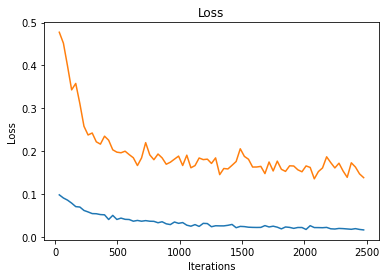

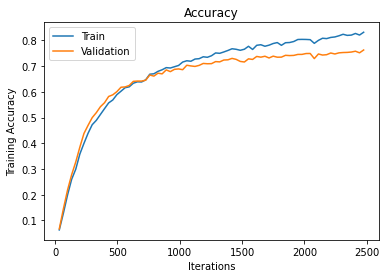

Final Training Accuracy: 0.8321192052980132
Final Validation Accuracy: 0.7630633762020623


In [ ]:
use_cuda = True

model = AudioClassifier()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

import warnings
warnings.filterwarnings("ignore")
train(model, learning_rate=0.001, batch_size=1500, num_epochs=75, print_trace=True)

In [ ]:
_, _, test_loader = get_data_loader(1)
model_path = "/content/model_bs1500_lr0.001_epoch74"
model_state = torch.load(model_path)
model = AudioClassifier()
model.load_state_dict(model_state)
acc = get_accuracy(model.cuda(), test_loader)
print("The testing accuracy is: " + str(acc))

The testing accuracy is: 0.7634491634491635
